# Advanced Lane-Line
The following notebook contains sample imagery, descriptions, and simple templated sources. It cannot stand without the accompanying sources in this repository.

In [1]:
import os
import matplotlib
from scipy import misc
from moviepy.editor import VideoFileClip

%matplotlib inline

%run src/util.py
%run src/viz.py

print("Loaded external sources.")

Loaded external sources.


## Camera calibration
Relevant sources are in `calibrator.py`.

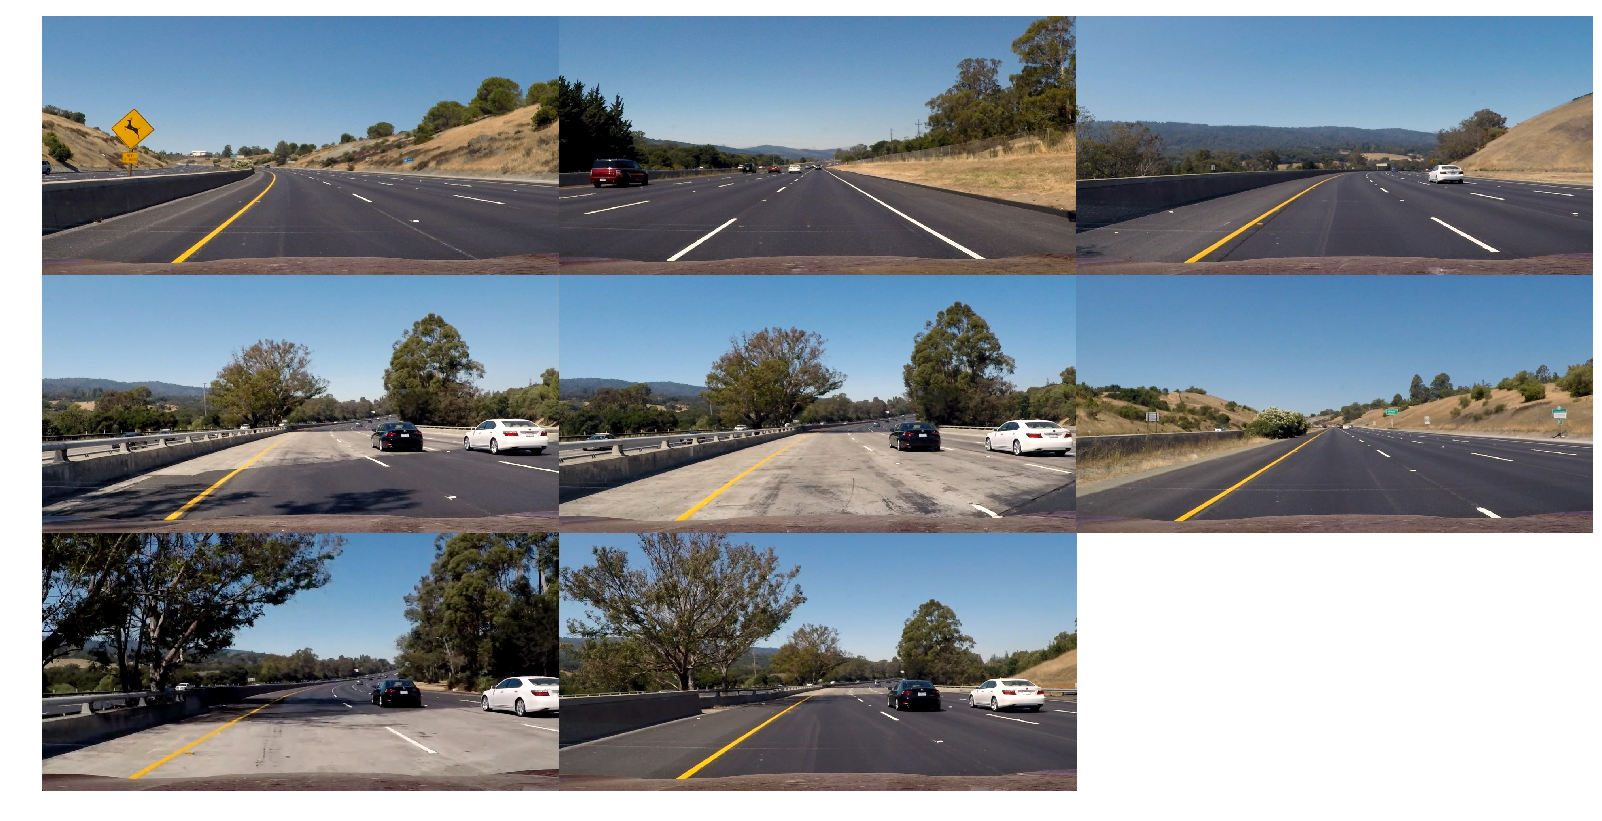

In [2]:
# The test images are loaded into memory (there is sufficient memory).
test_images = [misc.imread(image_path) for image_path in abswalk('./test_images')]

# A view of the original test images.

figure_1 = mosaic(test_images, 10, 20, 3)
figure_1.show()


N/A% (0 of N/A) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Preparing calibrator.


100% (20 of 20) |#########################| Elapsed Time: 0:00:15 Time: 0:00:15


Calibrator prepared.


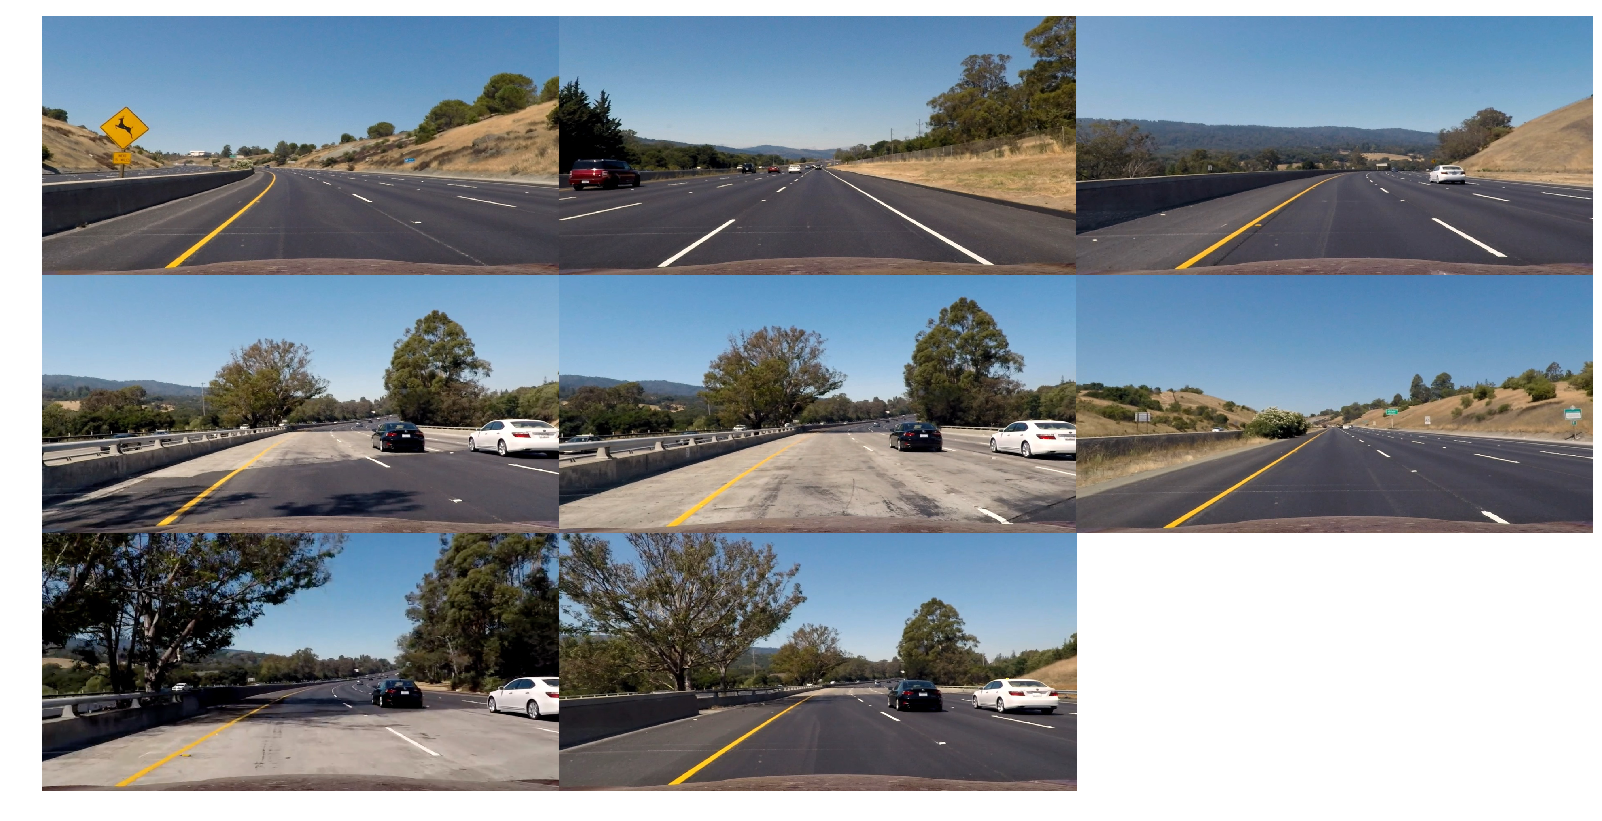

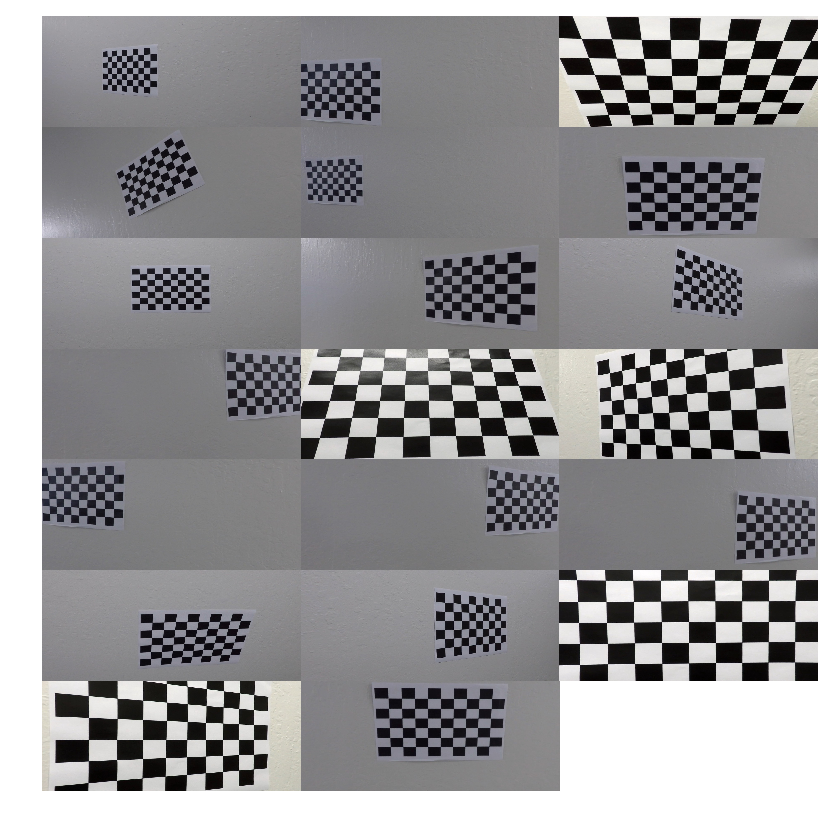

In [3]:
%run src/calibrator.py

calibration_image_paths = abswalk('camera_cal')
calibration_images = [misc.imread(image_path) for image_path in calibration_image_paths]

# See calibrator.py for details of this class.
print("Preparing calibrator.")
cal = Calibrator((9,6), calibration_image_paths)
print("Calibrator prepared.")

calibrated_test_images = [cal.undistort(image) for image in test_images]

figure_2 = mosaic(calibrated_test_images, 10, 20, 3)
figure_2.show()

calibrated_cal_images = [cal.undistort(image) for image in calibration_images]

figure_3 = mosaic(calibrated_cal_images, 10, 10, 3)
figure_3.show()


## Perspective alteration
Relevant sources are in `perspectifier.py`. The source and image points are selected from the image
`straight_lines1.jpg`

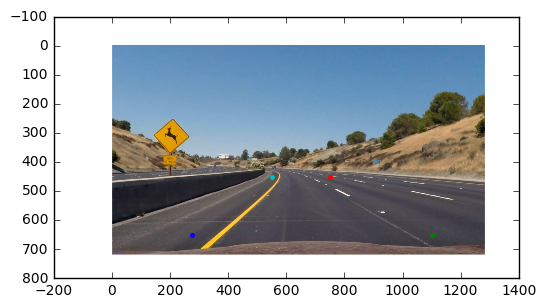

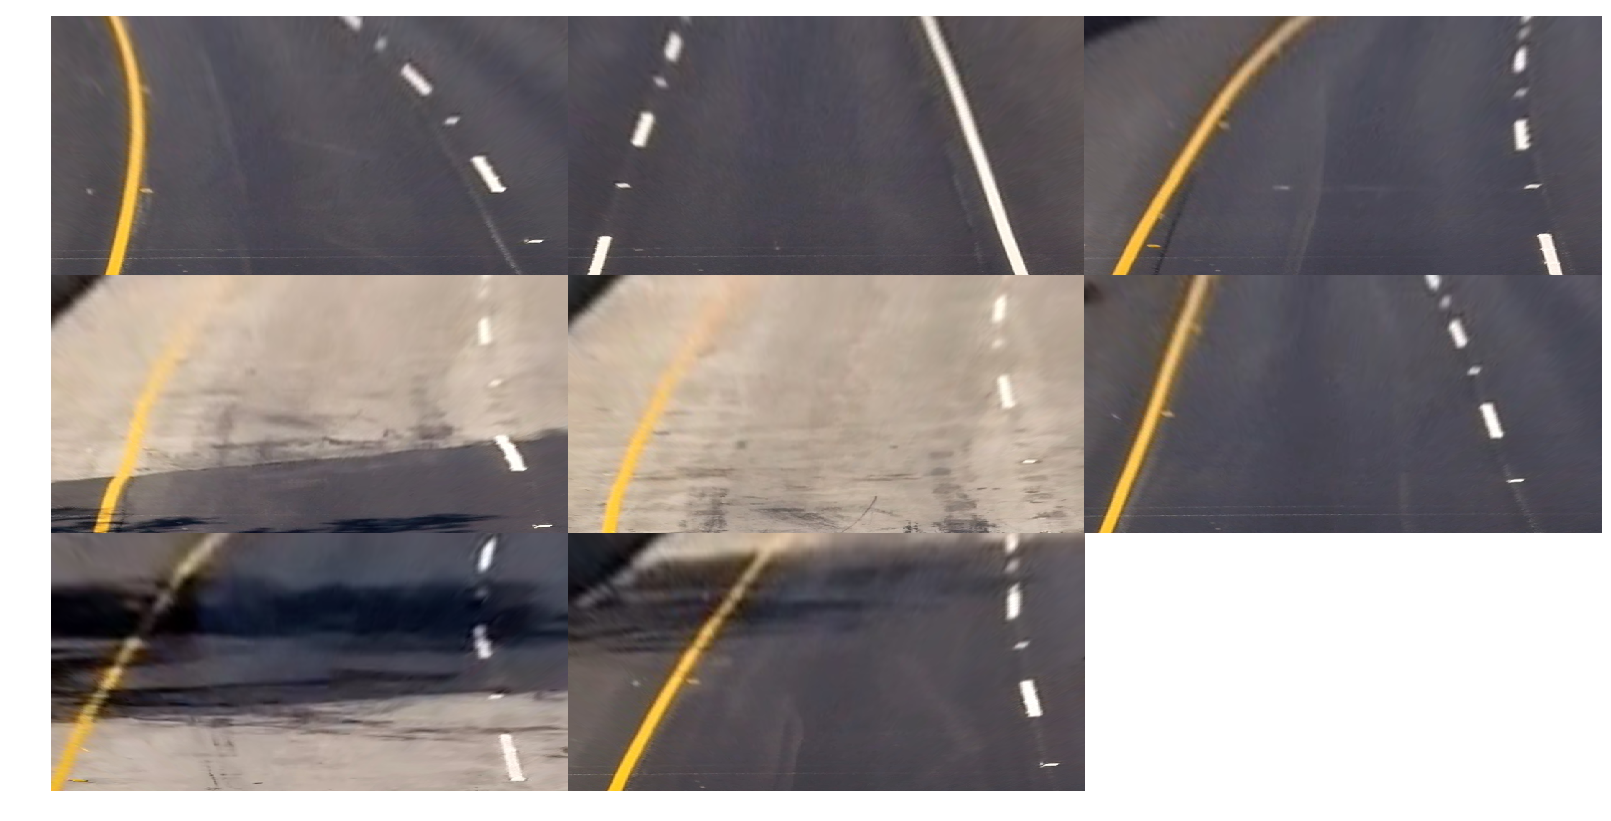

In [4]:
%run src/perspectifier.py

image_shape = test_images[0].shape

source_points = np.array([[275, 650], [1100,650], [750, 450], [550, 450]], np.float32)
destination_points = np.array([[0, image_shape[1]],
                                [image_shape[0], image_shape[1]],
                                [image_shape[0], 0], 
                                [0, 0]], np.float32)
plt.imshow(calibrated_test_images[0])
for point in source_points:
    plt.plot(point[0], point[1], '.')

# See perspectifier.py for details of this class
per = Perspectifier(source_points = source_points, destination_points = destination_points)

per_test_images = [per.perspectify(image) for image in calibrated_test_images]
figure_4 = mosaic(per_test_images, 10, 20, 3)
figure_4.show()

## Further pre-processing 
Aside from the above transforms, the images on which lane lines are to be detected are pre-processed as follows: 

- Contrast Limited Adaptive Histogram Equalization (CLAHE) 
- Guassian normalization 
- Conversion to Grayscale 
    - Sobel (x) 
    - Sobel (y) 
- Conversion to HLS color space 
    - Extraction of only the S channel 

The procedure returns three images corresponding, respectively, to the gradient in the x direction , the gradient in the y direction, and the S-channel of the input color image. CLAHE is applied prior to the two following steps, which are performed on the same input.  

Further details are in the `preprocess.py` module.

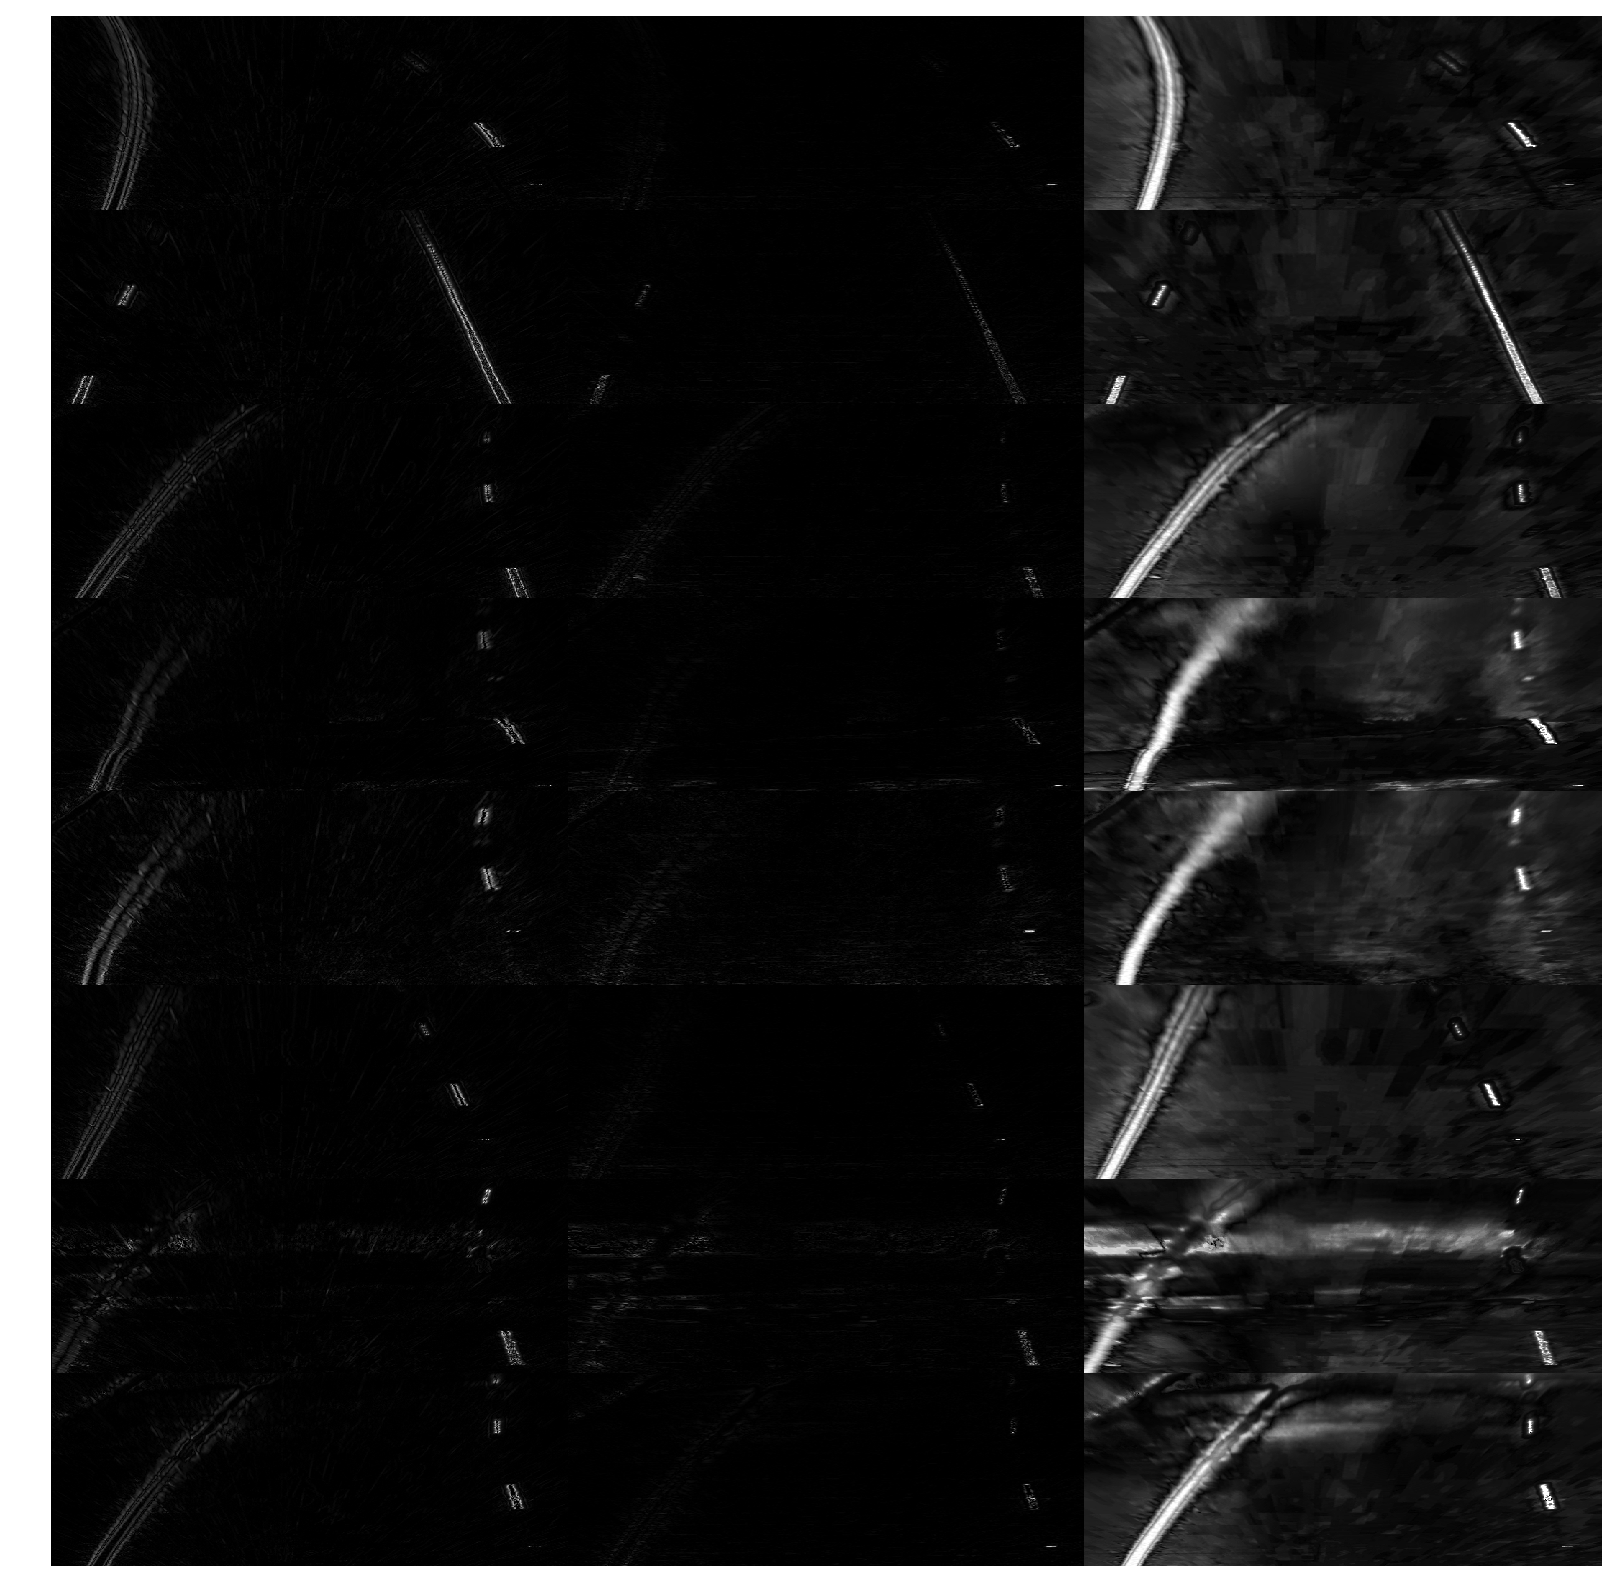

In [5]:
%run src/preprocess.py

proc_test_images = [preproc(image) for image in per_test_images]

plot_proc_test_images = [image for image_set in proc_test_images for image in image_set]
figure_5 = mosaic(plot_proc_test_images, 20, 20, 3, cmap='gray')
figure_5.show()


** Figure 5** Above, each row pertains to a separate test image. The columns, from left to right, contain (1) The scaled, absolute value of the gradient in the x direction, (2) The scaled, absolute value of the gradient in the y directon, and (3) The S-channel of test image. CLAHE is applied before the computation of (1), (2), and (3). 

## Thresholding 

With the above images as starting points, hresholds are applied to the gradient magnitudes, the gradient direction, and the image the s-channel, to expose the lane lines as clearly as possible. This is the final step prior to the application of the detection procedure.  
--- udpate because we're taking the gradient of the S channel --- 

Thresholding is controlled by simple helper sources in `threshold.py`. 

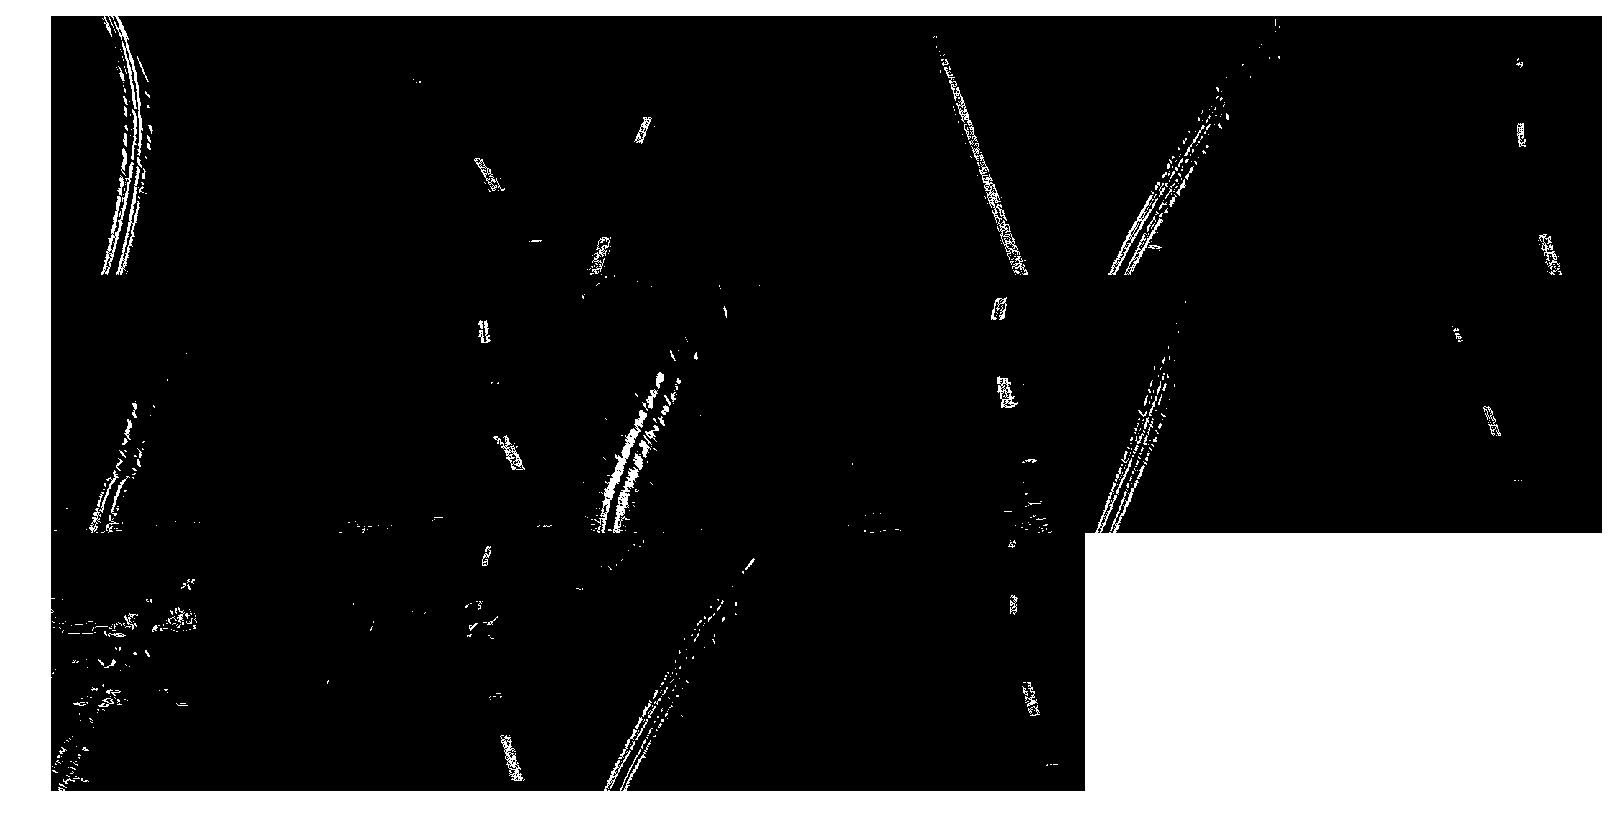

In [6]:
# Compute the magnitude and direction of the test iamge gradients.
%run src/treshold.py
import numpy as np

test_image_dx   = [sx for sx, _, _, in proc_test_images]
test_image_dy   = [sy for _, sy, _, in proc_test_images]

dx   = [bithreshold(image, 40, 100, '>=', '<=') for image in test_image_dx]
dy   = [bithreshold(image, 40, 100, '>=', '<=') for image in test_image_dy]

f2 = np.array([dxi | dyi for dxi, dyi in zip(dx, dy)], dtype=np.uint8)
mosaic(f2, 10, 20, 3, cmap='gray').show()


The approach taken here, as illustrated above, is to take a combination of a number of available images. The 

##  Lane Detection 

Sources relevant to what follows are contained in `line.py`, which defines the parameters required to identify a lane line, and `laneomatic.py` which defines the detection pipeline based on sliding windows, for primary detection.

### Primary Detection 

The detection pipeline can either operate through what is defined here as 'primary' or 'secondary' detection. Primary detection is applied to still images, or the first frame of video images. This approach, as mentioned above, uses histogram analysis to initialize a sliding window search for pixels likely to be part of lane lines. A second-degree polynomial is then fit to each potential lane marker. 

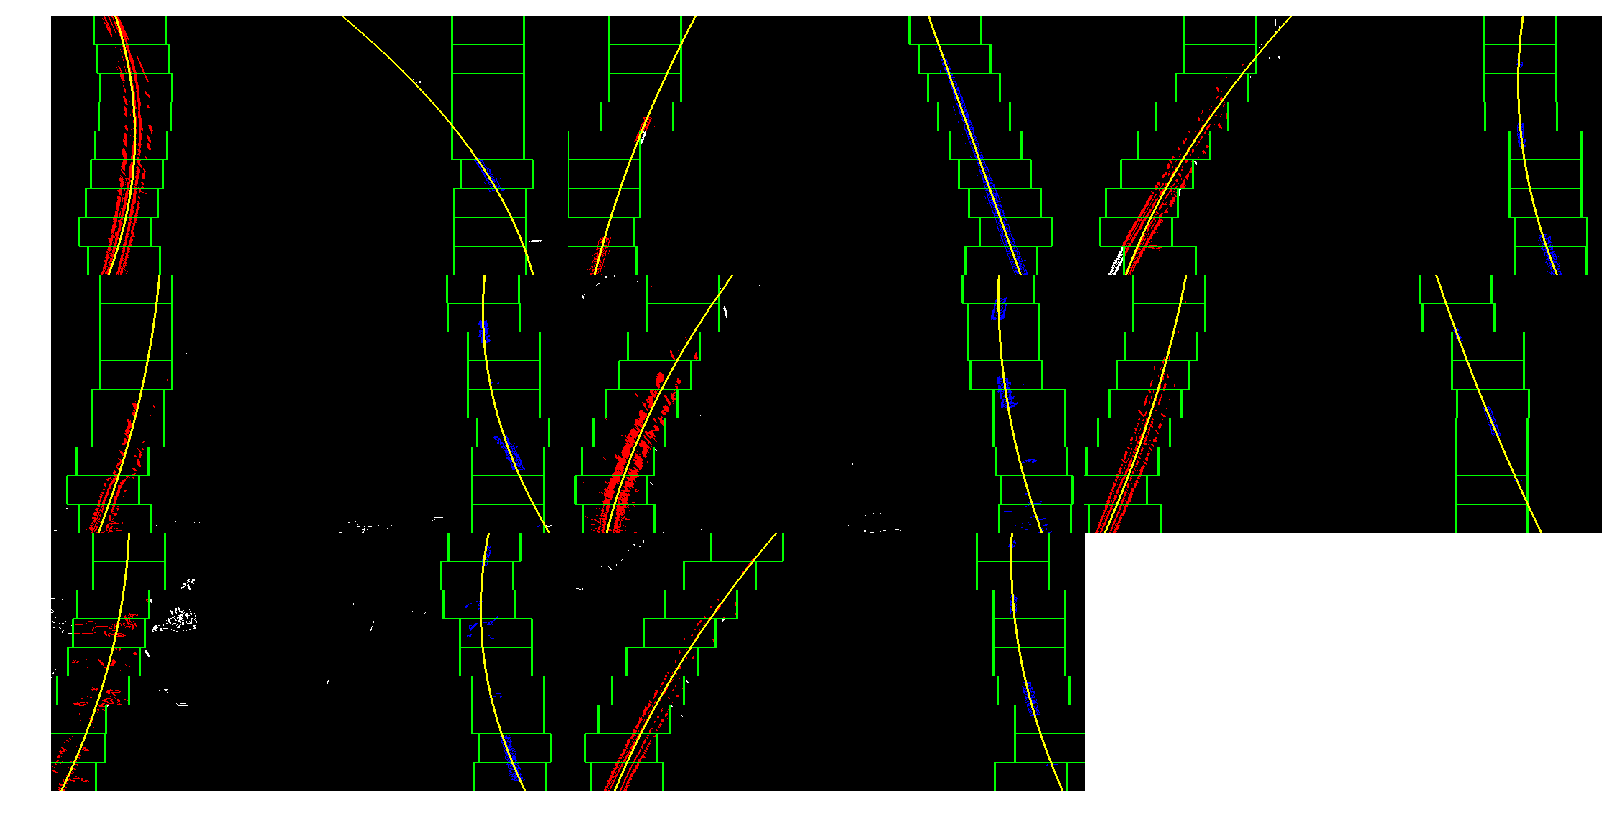

In [7]:
%run src/laneomatic.py

lane_detector = LaneOMatic(primary_only=True)

sw_lanes = [lane_detector.detect_lanes(image) for image in f2]
mosaic(sw_lanes, 10, 20, 3).show()

### Secondary Detection 

Secondary detection is only applicable to the analysis of video streams - given the polynomials defining the left and right lane lines obtained from the primary detection phase, a boundary is applied around the polynomial and its parameters are updated based on the pixels within that boundary which appear to be part of a lane line. Exponential smoothing is applied to the parameters. 

Prior to the application of this procedure, a template method is defined below, enabling the application of the detecton procedure to video streams. 

In [8]:
# The calibrator, perspective transform etc. are defined earlier in the notebook. We apply the same defaults here. 

def build_processor(calibrator=cal, perspectifier=per, preprocessor=preproc, detector=LaneOMatic()): 
    def processor(image): 
        image_working = cal.undistort(image)
        image_working = per.perspectify(image_working)
        dx, dy, _ = preproc(image_working)

        ## Recall that we are taking the gradient of the s-channel here  
        dx   = bithreshold(dx, 40, 100, '>=', '<=') 
        dy   = bithreshold(dy, 40, 100, '>=', '<=') 

        image_working = (dx | dy) 
    
        output_image = detector.detect_lanes(image_working)
    
        return output_image
    return processor 

In [9]:
video0_output = 'project_video_testing.mp4'
processor = build_processor()

video0 = VideoFileClip("project_video.mp4")
video0_processed = video0.fl_image(processor)

%time video0_processed.write_videofile(video0_output, audio=False)

[MoviePy] >>>> Building video project_video_testing.mp4
[MoviePy] Writing video project_video_testing.mp4


100%|█████████▉| 1260/1261 [05:38<00:00,  3.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_testing.mp4 

CPU times: user 40min 38s, sys: 1min 8s, total: 41min 46s
Wall time: 5min 38s
